# DL3: Spectrum and light curve from DL3

This notebook must be used with a gammapy version v0.20 or higher. Here we will use `gammapy v1.0`.

In this notebook we will take a deeper look on the MAGIC+LST DL3 and compute a counts map, a significance curve in terms of livetime, an SED modelled with the following LogParabola  

## $ \Phi =  \Phi_0 \left(\frac{E}{E_{ref}}\right)^{\alpha + \beta\log_{10}(E/E_{ref})},     $

and a light curve.

We will also compare the SED with the archival Crab spectrum, which has $\Phi_0 = 3.23\times 10^{-11}$ cm$^{-2}$ s$^{-1}$ TeV$^{-1}$, $E_{ref} = 1$ TeV, $\alpha = -2.47$, and $\beta = -0.24$.


### As usual, let's start by loading some modules (and checking the `gammapy` version)

In [61]:
import itertools
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from matplotlib import pyplot as plt

In [62]:
# We need to use gammapy v0.20 or later.

import gammapy

print(f"gammapy: v{gammapy.__version__}")

from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset
from gammapy.estimators import FluxPointsEstimator, LightCurveEstimator
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
)
from gammapy.maps import Map, MapAxis, RegionGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    PowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)
from gammapy.visualization import plot_spectrum_datasets_off_regions
from regions import CircleSkyRegion, PointSkyRegion

gammapy: v1.0


In [63]:
# Customize the pyplot figure
plt.rcParams.update(
    {"figure.figsize": (12, 9), "font.size": 15, "grid.linestyle": "--"}
)

# Get the default color cycle
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

### Load DL3 files

Here we load the DL3 files. The first thing we do is providing the directories where the DL3 runs and index files are stored.

In this example we use the data available in the directory  
`./data/`  

In this dataset we will use a simple average between the three telescopes DL2 parameters.

Let's start by creating a DataStore object from the input directory and take a look at it.

In [64]:
input_dir = './data'

data_store = DataStore.from_dir(input_dir)

# Show the observation table
data_store.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes22,bytes22
2923,2020-11-18,23:35:47.530,2020-11-18,23:52:39.650,83.9669730680169,22.24639350166312,45.06128940564784,44.93871059435216,86.40450658540857,83.633083,22.0145,1605742547.530164,1605743559.649549,448.4662706851959,1012.11938476562,406.4868126480223,0.9063932768610788,Crab,WOBBLE,3,LST-1_MAGIC-I_MAGIC-II,LST-1_MAGIC-I_MAGIC-II
2924,2020-11-18,23:56:14.698,2020-11-19,00:15:55.933,83.26503262048294,21.7876915585711,40.10371827458638,49.89628172541362,89.6596903830588,83.633083,22.0145,1605743774.698224,1605744955.932863,522.5848009586334,1181.234639644619,474.3752223940939,0.9077478363777448,Crab,WOBBLE,3,LST-1_MAGIC-I_MAGIC-II,LST-1_MAGIC-I_MAGIC-II
3093,2020-12-07,23:34:47.190,2020-12-07,23:36:13.471,83.97885081403817,22.24526920857109,28.896547521311618,61.10345247868838,95.75666061818394,83.633083,22.0145,1607384087.190233,1607384173.470571,37.60797905921936,86.28033828735582,35.3974765506659,0.9412225127791979,Crab,WOBBLE,3,LST-1_MAGIC-I_MAGIC-II,LST-1_MAGIC-I_MAGIC-II
3265,2020-12-15,21:27:18.415,2020-12-15,21:41:43.146,83.96475780330954,22.247863563275,49.9494782005039,40.0505217994961,84.08107653962642,83.633083,22.0145,1608067638.414856,1608068503.145767,467.440105676651,864.7309117317188,444.6016194612285,0.9511413634857834,Crab,WOBBLE,3,LST-1_MAGIC-I_MAGIC-II,LST-1_MAGIC-I_MAGIC-II
3266,2020-12-15,21:43:24.497,2020-12-15,21:57:30.340,83.26300698928598,21.7877022954978,45.96227389775927,44.03772610224073,86.64186055227022,83.633083,22.0145,1608068604.496795,1608069450.340243,458.9710812568665,845.8434472083973,437.3841889869011,0.9529667703445479,Crab,WOBBLE,3,LST-1_MAGIC-I_MAGIC-II,LST-1_MAGIC-I_MAGIC-II
3267,2020-12-15,21:59:19.731,2020-12-15,22:12:55.540,83.96675054673734,22.24606302455202,42.93517607753816,47.06482392246184,87.45572611833191,83.633083,22.0145,1608069559.731362,1608070375.540113,431.6227631568909,815.8087511062604,411.4869548248586,0.9533485949981902,Crab,WOBBLE,3,LST-1_MAGIC-I_MAGIC-II,LST-1_MAGIC-I_MAGIC-II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,2021-02-13,23:09:15.761,2021-02-13,23:26:01.650,83.28785259632826,21.78673659083378,27.93920269216776,62.06079730783224,262.4862245311674,83.633083,22.0145,1613257755.761256,1613258761.65026,393.5324034690857,1005.889004707335,379.1737119942353,0.963513318475747,Crab,WOBBLE,3,LST-1_MAGIC-I_MAGIC-II,LST-1_MAGIC-I_MAGIC-II


Let's take a look at the features of the observations (i.e. the runs).

In the cell below, if we set `obs_ids = None` this means that we will process all of the runs. If you want to use only some of the runs, please insert instead a list of comma-separated runs.

In [65]:
obs_ids = None   # `None` means "all" observations

observations = data_store.get_observations(obs_ids, required_irf="point-like")

print(observations)

Observations
Number of observations: 16
Observation

	obs id            : 2923 
 	tstart            : 59171.98
	tstop             : 59171.99
	duration          : 1012.12 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 9.4%
Observation

	obs id            : 2924 
 	tstart            : 59172.00
	tstop             : 59172.01
	duration          : 1181.23 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 9.2%
Observation

	obs id            : 3093 
 	tstart            : 59190.98
	tstop             : 59190.98
	duration          : 86.28 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 5.9%
Observation

	obs id            : 3265 
 	tstart            : 59198.89
	tstop             : 59198.90
	duration          : 864.73 s
	pointing (icrs)   : 84.0 deg, 22.2 deg

	deadtime fraction : 4.9%
Observation

	obs id            : 3266 
 	tstart            : 59198.90
	tstop             : 59198.91
	duration          : 845.84 s
	pointing (icrs)   : 83.3 deg, 21.8 

### Define a target region

Here we will collect the target position from observations metadata. To define the `on_region` we use `CircleSkyRegion` in case of global theta cuts, `PointSkyRegion` in case of dynamic theta cuts.

In [66]:
# Get metadata from the first observation
observation = observations[0]

event_meta = observation.events.table.meta
aeff_meta = observation.aeff.meta

# Collecting the target position
target_position = SkyCoord(
    u.Quantity(event_meta["RA_OBJ"], u.deg),
    u.Quantity(event_meta["DEC_OBJ"], u.deg),
    frame="icrs",
)

if "RAD_MAX" in aeff_meta:
    # Get the global theta cut used for creating the IRFs
    on_region_radius = aeff_meta["RAD_MAX"] * u.deg
    
    # Use the circle sky region to apply the global theta cut
    on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)
    
else:
    # Use the point sky region to apply dynamic theta cuts
    on_region = PointSkyRegion(target_position)
    
print("Position of the ON region: \n",on_region)

Position of the ON region: 
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>
radius: 0.2 deg


### Running the data reduction chain

Here we create the energy axes (reconstructed and true energy) and we set the number of OFF regions.

We also create the Gammapy Makers needed to process the data.

In [67]:
# ================
# === Settings ===
# ================

energy_min = "0.030 TeV"
energy_max = "30. TeV"
n_bins_pdec = 5

true_energy_min = "0.01 TeV"
true_energy_max = "100 TeV"
n_bins_pdec_true = 10

n_off_regions = 3

# ============
# === Main ===
# ============

energy_axis = MapAxis.from_energy_bounds(
    energy_min,
    energy_max,
    nbin=n_bins_pdec,
    per_decade=True,
    name="energy",
)

energy_axis_true = MapAxis.from_energy_bounds(
    true_energy_min,
    true_energy_max,
    nbin=n_bins_pdec_true,
    per_decade=True,
    name="energy_true",
)

on_geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=on_geom, energy_axis_true=energy_axis_true)

# Create a spectrum dataset maker
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "exposure", "edisp"],
    use_region_center=True,
)

# Create a background maker
print(f"\nNumber of OFF regions: {n_off_regions}")

region_finder = WobbleRegionsFinder(n_off_regions=n_off_regions)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# Create a safe mask maker
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)


Number of OFF regions: 3


Now we apply the makers to the observations to create new datasets that contain the number of events, number of excess and background events, exposure and $\delta = 1/R_{OFF}$, where $R_{OFF}$ is the number of OFF regions. We will use this $\delta$ later to compute the Li & Ma significance.


In [68]:
datasets = Datasets()

counts = Map.create(skydir=target_position, width=3)

# Loop over every observation
print("Running the makers...")

n_observations = len(observations)

for i_obs, observation in enumerate(observations):
    
    if (i_obs % 10) == 0:
        print(f"{i_obs}/{n_observations}")
    
    obs_id = observation.obs_id
    
    # Fill the number of events in the map
    counts.fill_events(observation.events)

    # Run the makers to the observation data
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)

    datasets.append(dataset_on_off)

print(f"{n_observations}/{n_observations}")

# Get the information table
info_table = datasets.info_table(cumulative=True)
print(datasets.energy_ranges)
# Show the table
info_table

Running the makers...
0/16
10/16
16/16
(<Quantity [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03,
           0.03, 0.03, 0.03, 0.03, 0.03, 0.03] TeV>, <Quantity [30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30., 30.,
           30., 30., 30.] TeV>)


name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,291,249.3333282470703,19.239705414082263,41.66666793823242,104.00000232458112,104.00000232458112,nan,831.2355346679688,294420960.0,917.378205732334,1012.119384765625,0.3172083206050198,0.04541929127798532,0.2717890251687743,15,11,wstat,381.76888381802354,125,11.0,33.0,0.3333333432674408
stacked,637,547.0,28.58253368630377,90.00000762939453,226.750013735145,226.750013735145,nan,6964.11376953125,580374656.0,1989.6413941241854,2193.354024410248,0.3201581962866224,0.045234285884472855,0.27492391423670715,15,11,wstat,835.1737831398044,270,11.0,32.999996185302734,0.3333333730697632
stacked,669,574.0,29.246404119448727,95.00000762939453,238.5000142995264,238.5000142995264,nan,103.11920928955078,596127488.0,2070.8503909304472,2279.6343626976013,0.3230556890685926,0.04587487731873782,0.2771808154340391,15,12,wstat,878.9978714895968,285,12.0,35.999996185302734,0.3333333730697632
stacked,808,697.0,32.465030158250435,111.0,285.250014942139,285.250014942139,nan,103.11920928955078,934389760.0,2893.33172936326,3144.3652744293213,0.2792628276253058,0.038364076567337806,0.240898751057968,15,12,wstat,1079.7085862941956,333,12.0,36.0,0.3333333432674408
stacked,1095,933.0,36.94106510742606,162.0,395.25001128204144,395.25001128204144,nan,103.11920928955078,1206477568.0,3699.3924274665524,3990.208721637726,0.29599455085382403,0.04379097464686712,0.25220357620695694,15,12,wstat,1413.2517049428939,486,12.0,36.0,0.3333333432674408
stacked,1339,1135.3333740234375,40.48766100499071,203.6666717529297,487.50002571567825,487.50002571567825,nan,103.11920928955078,1438180352.0,4477.1425541209355,4806.017472743988,0.29907468520686986,0.04549032542318024,0.2535843700081501,15,12,wstat,1693.6535454537177,611,12.0,36.0,0.3333333432674408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
stacked,2543,2148.66650390625,55.44434066448244,394.3333740234375,931.500064171849,931.500064171849,nan,10120.2861328125,2150021888.0,8470.685353287588,8970.858662366867,0.30021183575341126,0.046552711802757656,0.2536591095397403,15,13,wstat,3222.645140495215,1183,13.0,38.999996185302734,0.3333333730697632


### Counts map

Let's create a counts map including the ON-OFF regions. From the colors, we see that almost all of the events come from the Crab position, as expected. In the legend we list the run number for each set of OFF regions.

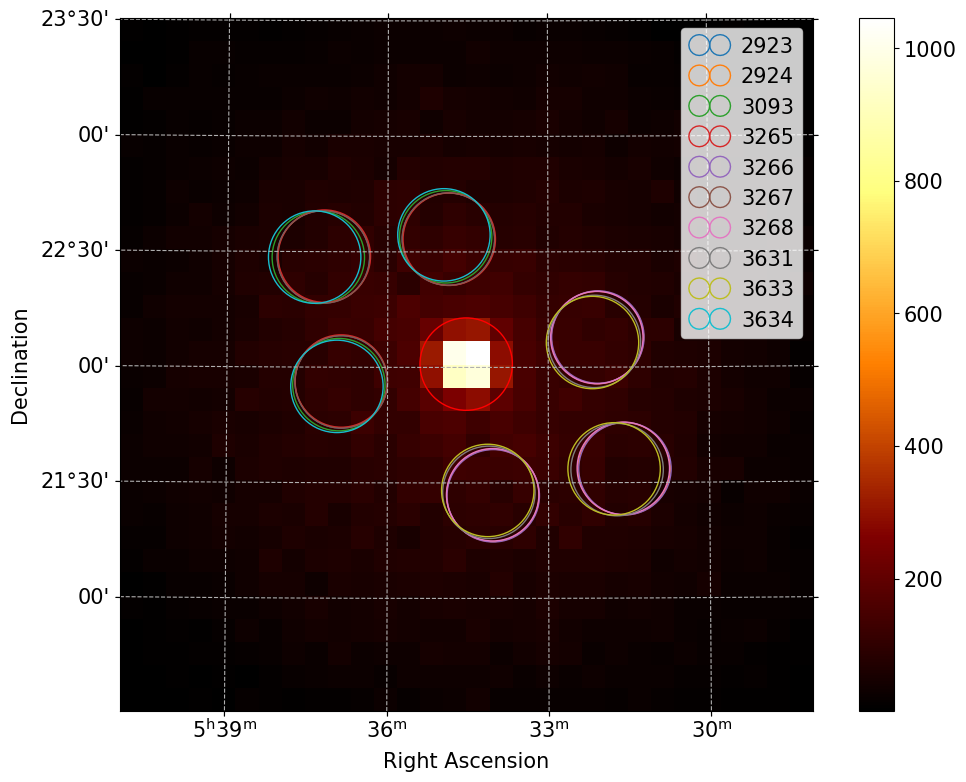

In [69]:
plt.figure()

# Plot the count map
ax = counts.plot(add_cbar=True)

# Plot the ON position
on_geom.plot_region(ax=ax, edgecolor="red")

# Plot the OFF positions (only the first part of observations)
if n_observations < 10:
    plot_spectrum_datasets_off_regions(datasets, ax)
else:
    plot_spectrum_datasets_off_regions(datasets[0:10], ax)

ax.grid()

Now let's plot the number of events and significance (i.e. sqrt(TS), in $\sigma$ units) in terms of livetime, which is the total amount of usefull time collecting data from the target, i.e. livetime $= t_{on} - t_{dead}$.

As expected, the number of excess events (and so the significance) increase faster than the background in terms of the livetime, reaching a 50 $\sigma$ signaficance in less than 2 hours (this is a very bright source).

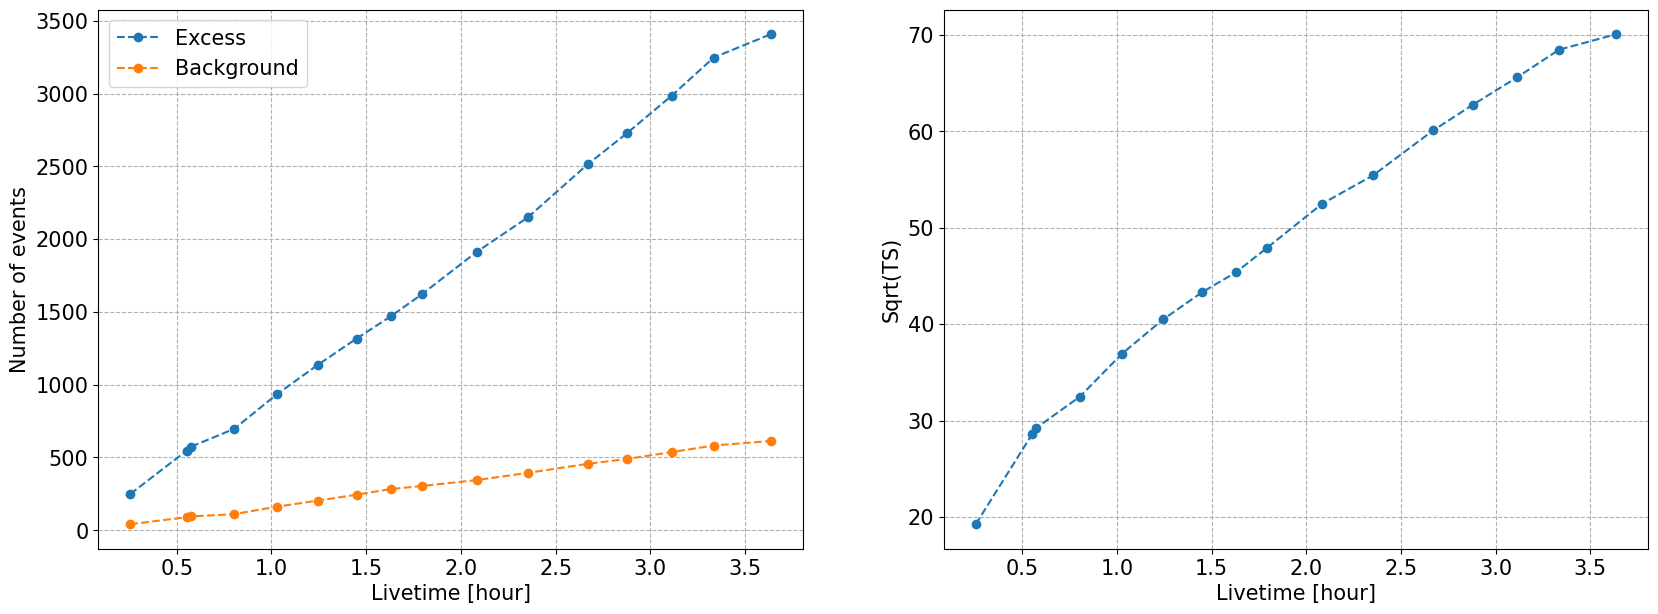

In [70]:
plt.figure(figsize=(20, 7))
grid = (1, 2)

# Plot the number of events along the livetime
plt.subplot2grid(grid, (0, 0))
plt.xlabel("Livetime [hour]")
plt.ylabel("Number of events")

plt.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    linestyle="--",
    label="Excess",
)

plt.plot(
    info_table["livetime"].to("h"),
    info_table["background"],
    marker="o",
    linestyle="--",
    label="Background",
)

plt.grid()
plt.legend()

# Plot the significance along the livetime
plt.subplot2grid(grid, (0, 1))
plt.xlabel("Livetime [hour]")
plt.ylabel("Sqrt(TS)")

plt.plot(
    info_table["livetime"].to("h"), info_table["sqrt_ts"], marker="o", linestyle="--"
)

plt.grid()

### Fitting the spectrum

We now fit the LogParabola model defined in the top of this notebook to our data. We start by creating a `SkyModel` and adding it to our datasets, we create a `Fit` that we will run on our data 

In [71]:
source_name="Crab Nebula"

spectral_model = LogParabolaSpectralModel(
    amplitude=u.Quantity(5e-12, unit="cm-2 s-1 TeV-1"),
    alpha=2,
    beta=0.1,
    reference=u.Quantity(1, unit="TeV"),
)

sky_model = SkyModel(spectral_model=spectral_model.copy(), name=source_name)

# Add the model to the stacked dataset
stacked_dataset = datasets.stack_reduce()
stacked_dataset.models = [sky_model]

# Create a fit object to run on the datasets
fit = Fit()

Here we apply the `fit` on the first sample to get the LogParabola parameters.

In [72]:
results = fit.run(datasets=stacked_dataset)
print(results)

# Keep the best fit model
best_fit_model = stacked_dataset.models[0].spectral_model.copy()

# Show the fitted parameters
stacked_dataset.models.to_parameters_table()

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 151
	total stat : 11.85

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,3.4456e-11,cm-2 s-1 TeV-1,9.912e-13,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.5278e+00,,2.923e-02,nan,nan,False,False,
Crab Nebula,spectral,beta,1.2966e-01,,1.888e-02,nan,nan,False,False,


Now let's check if the observations are in good agreement with the predictions. We do it by plotting the number of excess events and comparing it to the number of predicted events.

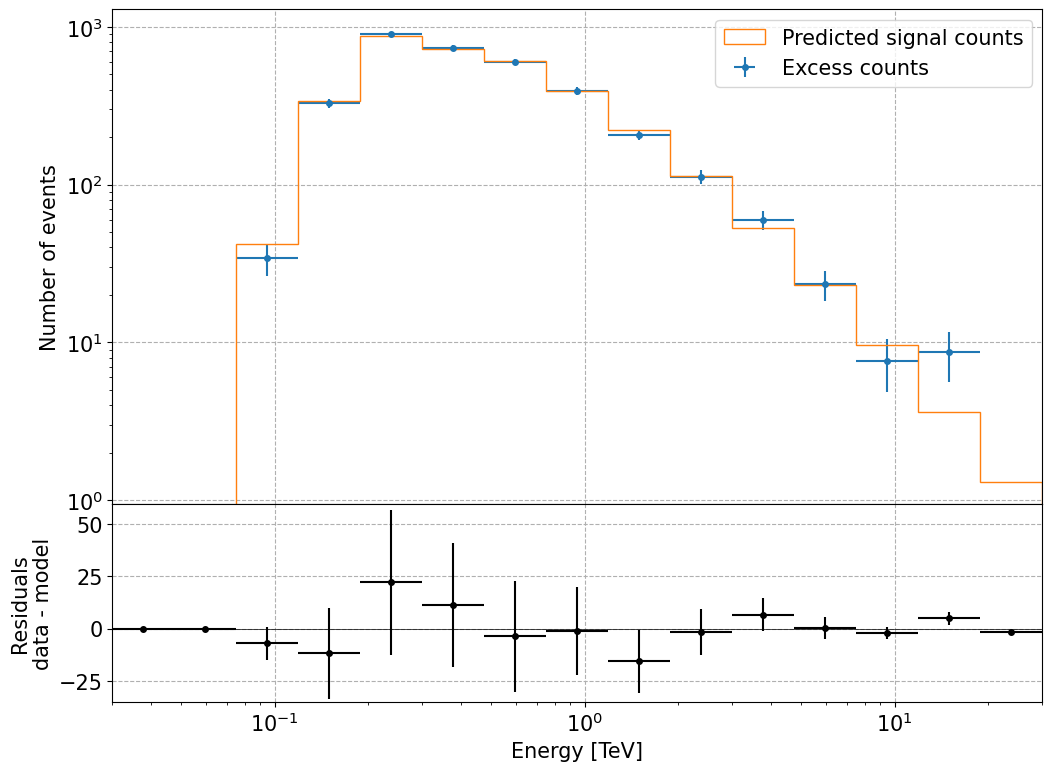

In [73]:
plt.figure()

# Plot the number of excess and predicted events
ax_spectrum, ax_residuals = stacked_dataset.plot_fit()

ax_spectrum.set_ylabel("Number of events")
ax_spectrum.grid()

plt.setp(ax_spectrum.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0)

ax_residuals.grid()

### Estimating the flux points

We create a `FluxPointsEstimator` object to be applied on our datasets in order to evaluate the SEDs (`sed_type="e2dnde"`)

In [74]:
# Create a flux point estimator
flux_points_estimator = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source=source_name, selection_optional="all"
)

In [75]:
# Run the flux point estimator to the datasets
print("Running the flux points estimator...")
flux_points = flux_points_estimator.run(datasets=stacked_dataset)

# Show the flux points table
flux_points.to_table(sed_type="e2dnde", formatted=True)

Running the flux points estimator...


e_ref,e_min,e_max,e2dnde,e2dnde_err,e2dnde_errp,e2dnde_errn,e2dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
TeV,TeV,TeV,TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool,float64[11],float64[11]
0.038,0.030,0.048,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.060,0.048,0.075,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,False,0.0,False,0.200 .. 5.000,nan .. nan
0.095,0.075,0.119,4.744e-11,1.087e-11,1.127e-11,1.049e-11,7.083e-11,26.388,5.137,54.99985097082418,34.333164,0.000,False,55.0,True,0.200 .. 5.000,13.926 .. 191.006
0.150,0.119,0.189,5.659e-11,3.732e-12,3.784e-12,3.681e-12,6.426e-11,363.515,19.066,433.00730790162316,328.0079,0.000,False,433.0,True,0.200 .. 5.000,208.939 .. 1496.714
0.238,0.189,0.300,5.777e-11,2.225e-12,2.245e-12,2.206e-12,6.230e-11,1124.073,33.527,1123.9928565985742,898.9924,0.000,False,1124.0,True,0.200 .. 5.000,666.126 .. 3750.625
0.378,0.300,0.475,5.176e-11,2.106e-12,2.128e-12,2.084e-12,5.608e-11,1107.461,33.279,849.8586241844911,732.8521,0.000,False,850.0,True,0.200 .. 5.000,643.475 .. 3214.895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.383,1.893,3.000,1.945e-11,1.945e-12,2.001e-12,1.890e-12,2.358e-11,204.510,14.301,121.97751569031567,111.9769,0.000,False,122.0,True,0.200 .. 5.000,114.852 .. 531.722


### Computing the SED

Below we show the SED with the flux points and best fit model. For comparison, we plot the Crab reference SED (MAGIC, JHEAp 2015).

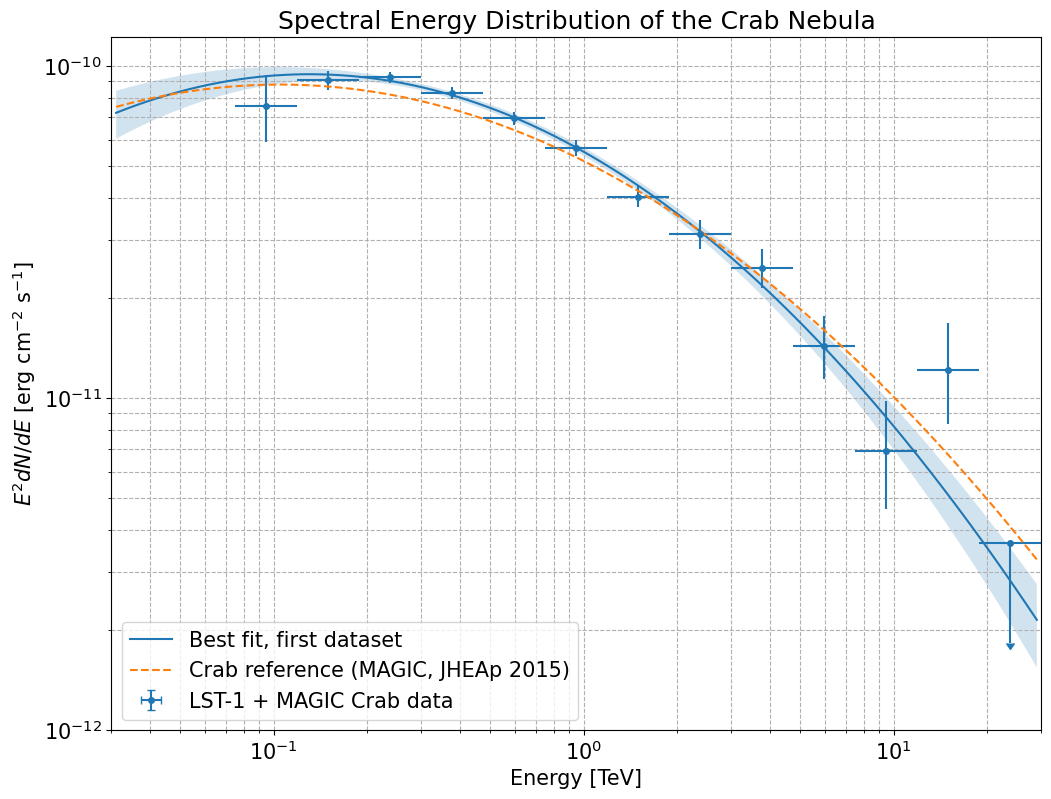

In [76]:
# ================
# === Settings ===
# ================

sed_type = "e2dnde"
yunits = u.Unit("erg cm-2 s-1")

crab_model = create_crab_spectral_model("magic_lp")
#print(crab_model)
reference_models = {
    "Crab reference (MAGIC, JHEAp 2015)": crab_model,
    
}

# ============
# === Main ===
# ============

plt.figure()

energy_bounds = energy_axis.edges[[0, -1]]

lines = itertools.cycle(["--", "-.", ":"])

# Plot the flux points
ax = flux_points.plot(sed_type=sed_type, label="LST-1 + MAGIC Crab data")


# Plot the best fit model and its error, first sample
best_fit_model.plot(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    color=colors[0],
    label="Best fit, first dataset"
)

best_fit_model.plot_error(
    ax=ax,
    energy_bounds=energy_bounds,
    sed_type=sed_type,
    yunits=yunits,
    facecolor=colors[0],
)


# Plot the reference spectra
for label, model in reference_models.items():

    model.plot(
        ax=ax,
        energy_bounds=energy_bounds,
        sed_type=sed_type,
        yunits=yunits,
        label=label,
        linestyle=next(lines)
    )

ax.set_title(f"Spectral Energy Distribution of the {source_name}")

ax.set_ylim(1e-12)
ax.set_ylabel("$E^2dN/dE$ [erg cm$^{-2}$ s$^{-1}$]")
ax.grid(which="both")
ax.legend(loc="lower left")

### Computing the light curve

For the light curve, we assume that the spectral shape parameters, $\alpha$ and $\beta$, do not change over the different time bins, i.e. we freeze them at their best-fit values achieved above.


In [77]:
frozen_params = ["alpha", "beta"]

sky_model = SkyModel(
    spectral_model=best_fit_model.copy(), name=source_name
)

# Freeze the spectral parameters
for param in frozen_params:
    sky_model.parameters[param].frozen = True
    
# Add the model to the datasets
datasets.models = [sky_model]

print(sky_model)


SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   3.45e-11   +/- 9.9e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    alpha                 (frozen):      2.528                   
    beta                  (frozen):      0.130                   




Now we create a `LightCurveEstimator`.

We must set energy edges and time intervals to be used to compute the light curve. If we adopt `time_intervals=None` we will get a run-wise LC, if instead we give it a list of Astropy Time objects, we can create e.g. a daily binned LC.

In [78]:
energy_edges = energy_axis.edges[[1,-1]]

#time_intervals = [
#    Time([59171.98, 59172.01], format="mjd", scale="utc"),
#    Time([59190.98, 59190.99], format="mjd", scale="utc"),
#    Time([59198.89, 59198.94], format="mjd", scale="utc"),
#    Time([59258.91, 59258.99], format="mjd", scale="utc"),
#    Time([59288.91, 59288.94], format="mjd", scale="utc"),
#    Time([59290.94, 59290.96], format="mjd", scale="utc"),
#]   # e.g. daily light curve 

time_intervals=None# `None` automatically makes a "run-wise" LC.

# ============
# === Main ===
# ============

# Create a light curve estimator
light_curve_estimator = LightCurveEstimator(
    energy_edges=energy_edges,
    time_intervals=time_intervals,
    source=source_name,
    selection_optional="all",
)

Now we run this estimator on the data sample (`sed_type="flux"`)

In [79]:
# Run the light curve estimator to the datasets
print("Running the light curve estimator...")
light_curve = light_curve_estimator.run(datasets=datasets)

# Show the light curve table
light_curve.to_table(sed_type="flux", format="lightcurve")


Running the light curve estimator...


time_min,time_max,e_ref,e_min,e_max,flux,flux_err,flux_errp,flux_errn,flux_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success,norm_scan,stat_scan
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,,,,,,,
float64,float64,float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],float64[1],"float64[1,16]","float64[1,16]",float64[1],bool[1],"float64[1,16]",bool[1],"float64[1,11]","float64[1,11]"
59171.98365410007,59171.9953684448,1.1943215116604917,0.04754679577383339,30.000000000000004,1.0106609816114907e-09,7.20090955085616e-11,7.331952019554418e-11,7.071788460650556e-11,1.159958632144907e-09,370.41548792240934,19.246181125678138,287.73803744327296 .. nan,244.98416137695312 .. nan,11.353407041682585,False,291.0 .. nan,True,0.2 .. 4.999999999999999,205.84967457587288 .. 1322.6394963576697
59171.997857434086,59172.011529131305,1.1943215116604917,0.04754679577383339,30.000000000000004,1.2013766259216724e-09,7.738467380921108e-11,7.867425278310615e-11,7.61129673881987e-11,1.361340847745187e-09,449.66047731777786,21.205199299176083,nan .. nan,nan .. nan,9.453887833272047,False,nan .. nan,True,0.2 .. 4.999999999999999,276.2694954534766 .. 1193.0586898029496
59190.98295572123,59190.983954336254,1.1943215116604917,0.04754679577383339,30.000000000000004,1.285994221239061e-09,2.6871552093103875e-10,2.846711780591144e-10,2.5319540456038635e-10,1.8880832451868335e-09,45.004151886500395,6.708513388709931,nan .. nan,nan .. nan,3.7022307513586834,False,nan .. nan,True,0.2 .. 4.999999999999999,32.306595855231784 .. 100.4723964357325
59198.89442822844,59198.90443668807,1.1943215116604917,0.04754679577383339,30.000000000000004,1.3157086664792067e-09,1.301632105523631e-10,1.3365895371734368e-10,1.2673843565971653e-10,1.5901632213596249e-09,202.55676809249627,14.232243958438046,nan .. nan,nan .. nan,10.920422825232485,False,nan .. nan,True,0.2 .. 4.999999999999999,136.79409606751653 .. 427.94372202132934
59198.90560973238,59198.91539958709,1.1943215116604917,0.04754679577383339,30.000000000000004,1.1809328518697074e-09,8.888452883762062e-11,9.054901188864642e-11,8.724980630718956e-11,1.365462966007881e-09,328.87380586135134,18.134878159539735,nan .. nan,nan .. nan,20.287937767848316,False,nan .. nan,True,0.2 .. 4.999999999999999,213.26097334079878 .. 943.6058207683207
59198.916665688004,59198.92610791892,1.1943215116604917,0.04754679577383339,30.000000000000004,1.020123282554245e-09,8.129966344466346e-11,8.291447699319424e-11,7.971046755338169e-11,1.1892313309538112e-09,285.6338852189013,16.900706648507374,nan .. nan,nan .. nan,8.993051664838285,False,nan .. nan,True,0.2 .. 4.999999999999999,163.4370173804694 .. 1057.8297596266257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59258.965230848815,59258.97687308266,1.1943215116604917,0.04754679577383339,30.000000000000004,8.947855453592268e-10,6.641260119883663e-11,6.766999356266526e-11,6.51710008589161e-11,1.032679402968837e-09,349.1026714978362,18.684289429834795,nan .. nan,nan .. nan,8.807469463648745,False,nan .. nan,True,0.2 .. 4.999999999999999,176.91272335648546 .. 1500.2452059460325


### LC plot

Finally, we plot the LC and compare it to the Crab reference flux.

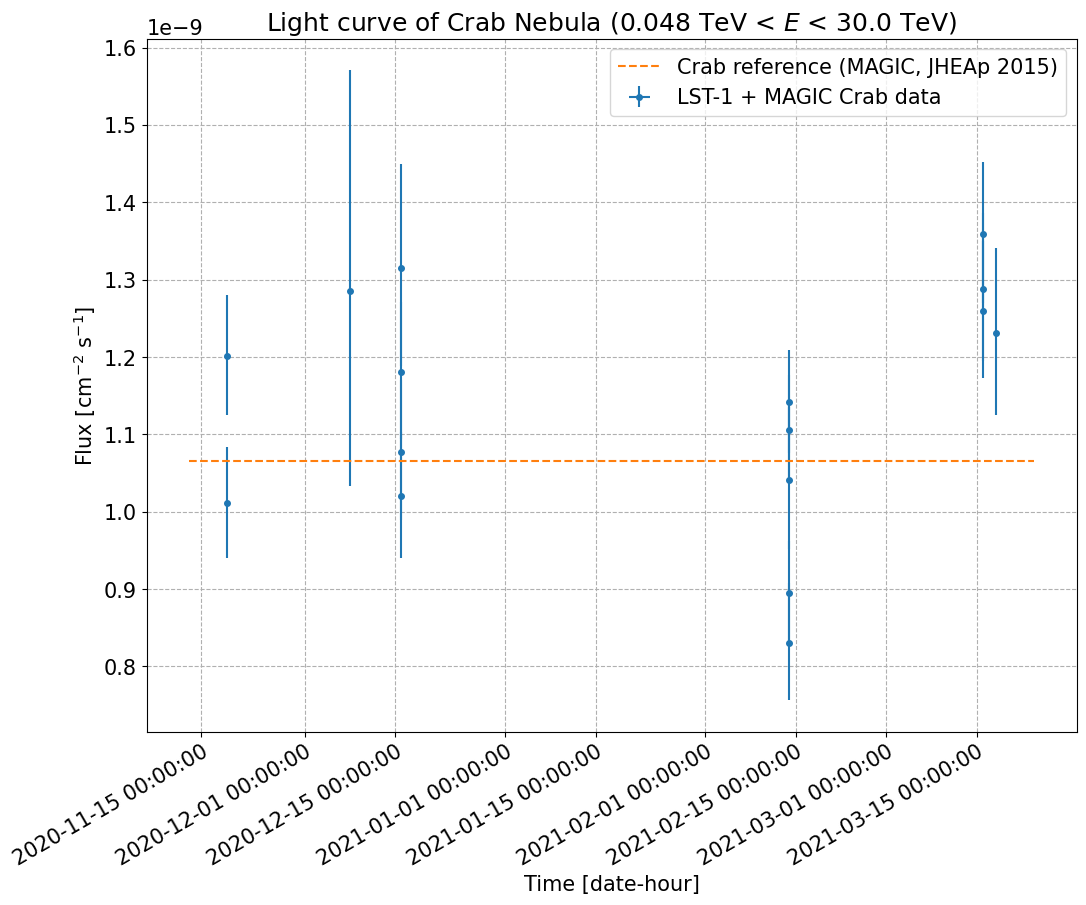

In [80]:
plt.figure()

lines = itertools.cycle(["--", "-.", ":"])

# Plot the light curve
ax = light_curve.plot(sed_type="flux", label="LST-1 + MAGIC Crab data")

xlim = plt.xlim()

# Plot the reference flux
for label, model in reference_models.items():
    
    integ_flux = model.integral(energy_edges[0], energy_edges[1])
    ax.plot(xlim, np.repeat(integ_flux, 2), label=label, linestyle=next(lines))

energy_range = f"{energy_edges[0]:.3f} < $E$ < {energy_edges[1]:.1f}"

ax.set_title(f"Light curve of {source_name} ({energy_range})")
ax.set_ylabel("Flux [cm$^{-2}$ s$^{-1}$]")
ax.set_xlabel("Time [date-hour]")
ax.set_yscale("linear")
ax.legend()
ax.grid()
